# Modeling Section #
## 1. Average loudness prediction

In this section, I'm going to see what pattern appears for average song loudness over the years, and predict the scenario for time to come.

In [1]:
# Collecting packages
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, round
import pandas as pd
import numpy as np

In [2]:
# Creating a context
sc = SparkContext()

In [3]:
# Starting Spark Session
spark = (
    SparkSession.builder                  
      .appName("music_spark_session")
      .getOrCreate()
)

In [4]:
path_data = "clean_data_music.csv"

schema_music = StructType([
    StructField('Index', IntegerType()),
    StructField('Track_duration', IntegerType()),
    StructField('Popularity', IntegerType()),
    StructField('Danceability', DoubleType()),
    StructField('Energy', DoubleType()),
    StructField('Key', IntegerType()),
    StructField('Loudness', DoubleType()),
    StructField('Acousticness', DoubleType()),
    StructField('Instrumentalness', DoubleType()),
    StructField('Liveness', DoubleType()),
    StructField('Valence', DoubleType()),
    StructField('Tempo', DoubleType()),
    StructField('Year', IntegerType())
])

In [5]:
df = spark.read.csv(
    path_data,
    header=True,
    sep=',',
    schema=schema_music
).drop('index')

In [6]:
df_loudness = df.select('Year', 'Loudness')\
                 .groupBy('Year').avg('Loudness').orderBy('Year')\
                 .withColumnRenamed('avg(Loudness)', 'Loudness')\
                 .withColumn('Loudness', round(col('Loudness'), 2))

In [7]:
df_loudness = df_loudness.toPandas()

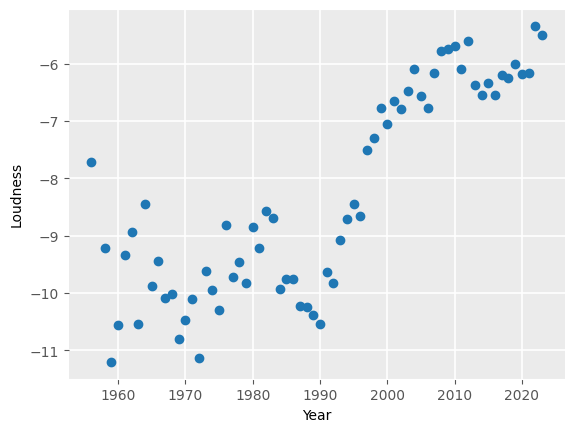

In [8]:
import matplotlib.pyplot as plt

ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.axisbelow':True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'grid.color': 'white',
    'grid.linewidth': '1.2',
    'xtick.color': '555555',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.color': '555555',
    'ytick.major.left': True,
    'ytick.minor.left': False,
}


plt.rcParams.update(ggplot_styles)

plt.scatter(df_loudness['Year'], df_loudness['Loudness'])
plt.xlabel('Year')
plt.ylabel('Loudness');

The range from 1990 to 2000 shows a very swift linear growth, but 2000 onwards the growth is softened, leading to a "halt" on approximately - 6.0 db in 2010 - 2020.

In [9]:
from sklearn.linear_model import LinearRegression

def fit_model(data, feature: str):
    X = data.drop(feature, axis = 1).copy()
    y = data[feature].copy()
    linear_reg = LinearRegression()
    linear_reg.fit(X, y)
    return X, y, linear_reg

#X = df_loudness.drop('Loudness', axis = 1).copy()
#y = df_loudness['Loudness'].copy()

#linear_reg = LinearRegression()
#linear_reg.fit(X, y);

model_1 = fit_model(df_loudness, 'Loudness')
X = model_1[0]
y = model_1[1]
linear_reg = model_1[2]

Try with 7th degree

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=7, include_bias=False)

X_poly = poly_features.fit_transform(X)

linear_reg.fit(X_poly, y)

y_fit_poly = linear_reg.predict(X_poly)

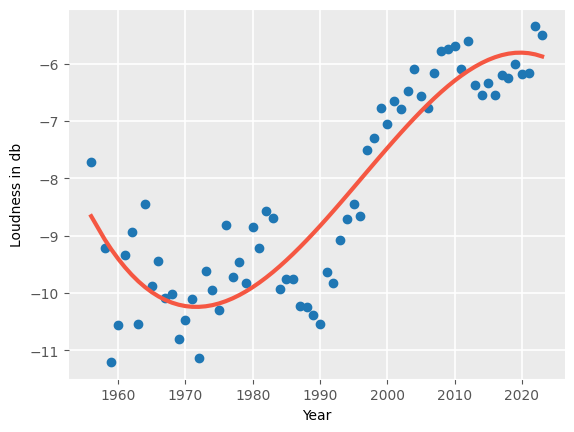

In [11]:
plt.scatter(X, y)
plt.plot(X, y_fit_poly, color = '#f55742', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Loudness in db');

According to this model, after 2020 the average loudness of song should decrease, but this model doesn't ajust so well to the data. So it's going to be used data from 1990 onwards to get a more apropriate model.

In [12]:
df_1990 = df_loudness[df_loudness["Year"]>= 1990].reset_index()
df_1990.drop(columns = 'index', inplace= True)
df_1990.head()

,Year,Loudness
0,1990,-10.54
1,1991,-9.63
2,1992,-9.82
3,1993,-9.08
4,1994,-8.71


In [13]:
model_2 = fit_model(df_1990, 'Loudness')
X = model_2[0]
y = model_2[1]
linear_reg = model_1[2]

In [14]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)

X_poly = poly_features.fit_transform(X)

In [15]:
linear_reg.fit(X_poly, y)

y_fit_poly = linear_reg.predict(X_poly)

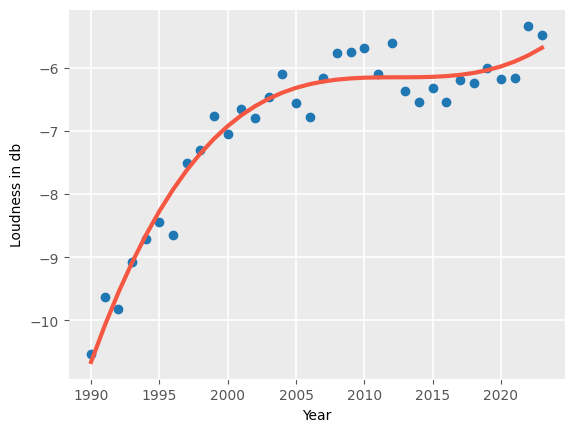

In [16]:
plt.scatter(X, y)
plt.plot(X, y_fit_poly, color = '#f55742', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Loudness in db');

In [17]:
years_list = [i for i in range(2024, 2031)]
df_future = pd.DataFrame(years_list, columns =['Year'])
df_future.head(10)

,Year
0,2024
1,2025
2,2026
3,2027
4,2028
5,2029
6,2030


In [18]:
df_2000 = df_loudness[df_loudness["Year"]>= 2000].reset_index()
df_2000.drop(columns = 'index', inplace= True)

In [19]:
model_3 = fit_model(df_2000, 'Loudness')
X = model_3[0]
y = model_3[1]
linear_reg = model_3[2]

In [20]:
y_pred_poly = linear_reg.predict(df_future)

In [21]:
# Simulate points with random
from numpy.random import seed
from numpy.random import randint

seed(0)

y_simulation_points = y_pred_poly + 1/10*randint(-5, 5, len(y_pred_poly))

In [22]:
y_pred_points = pd.DataFrame(y_simulation_points)

In [23]:
y_pred_points.rename(columns={0: "Loudness_pred"}, inplace= True)
y_pred_points.head(10)

,Loudness_pred
0,-5.773949
1,-6.239532
2,-5.905114
3,-5.870697
4,-5.436280
5,-5.201862
6,-5.767445


In [24]:
y_pred_points['Year'] = df_future

In [25]:
df_predictions = df_1990.merge(y_pred_points, how = 'outer', on = ['Year'])

In [26]:
poly_pred_curve = pd.concat([df_1990, y_pred_points.rename(columns={"Loudness_pred": "Loudness"})])
X = df_1990.drop('Loudness', axis = 1).copy()
X = pd.concat([X, df_future])
y = poly_pred_curve['Loudness'].copy()


In [27]:
from scipy.optimize import curve_fit

X = X.reset_index()
y = y.reset_index()

xdata = X['Year'].to_numpy()
ydata = y['Loudness'].to_numpy()

In [28]:
def log_model(x, a, b, c, d):
    return a * np.log(b * (x-c)) + d

init_vals = [10, 20, 1, 5]
popt, pcov = curve_fit(log_model, xdata, ydata, p0=init_vals)
y_pred = log_model(200, *popt)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_8864\1402104984.py:2: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * (x-c)) + d


C:\Users\Matheus\AppData\Local\Temp\ipykernel_8864\961137958.py:29: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend((historical, prediction),


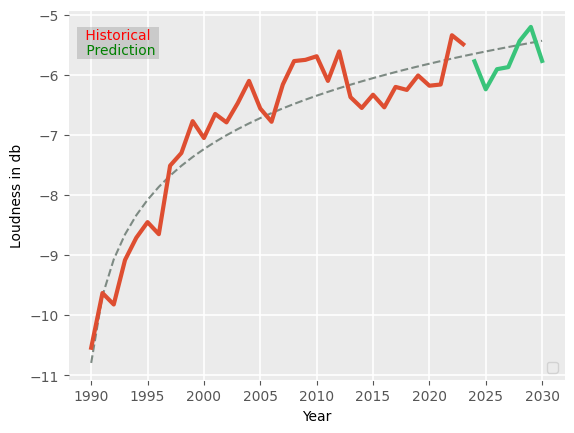

In [39]:
import matplotlib.patches as patches

fig, axs = plt.subplots(1,1)

t1 = axs.text(0.10,0.92, ' Historical ', ha='center', color='red', transform=axs.transAxes)
t2 = axs.text(0.10,0.88, ' Prediction', ha='center', color='green', transform=axs.transAxes)

fig.canvas.draw()

textobjs = [t1,t2]

xmin = min([t.get_window_extent().xmin - 4 for t in textobjs])
xmax = max([t.get_window_extent().xmax + 4 for t in textobjs])
ymin = min([t.get_window_extent().ymin - 2 for t in textobjs])
ymax = max([t.get_window_extent().ymax + 2 for t in textobjs])

xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, facecolor='grey', alpha=0.3, transform=fig.transFigure)

axs.add_patch(rect)

plt.plot(xdata, log_model(xdata, *popt), '--', color = '#7d8a83')
historical = plt.plot(df_predictions['Year'], df_predictions['Loudness'], color = '#de4e31', linewidth = 3)
prediction = plt.plot(df_predictions['Year'], df_predictions['Loudness_pred'], color = '#39c47a', linewidth = 3)
plt.xlabel('Year')
plt.ylabel('Loudness in db')
plt.legend((historical, prediction),
           ('Historical', 'Prediction'),
           loc='lower right',
           ncol=1,
           fontsize=10)
plt.show()

In [30]:
spark.stop()